# TopoFlow Snow Component Demo

#### Table of Contents

1.  <a href="#intro_S">Introduction</a> <br>
2.  <a href="#install_S">How to Install the TopoFlow Python Package</a> <br>
3.  <a href="#prepare_S">Prepare Some Input Files</a> <br>
4.  <a href="#get_cfg_S">Get Component CFG Files</a> <br>
5.  <a href="#set_info_S">Import TopoFlow and Set Basic Model Info</a> <br>
6.  <a href="#set_deg_day_S">Settings for a Run with the Degree-Day Snow Component</a> <br>
7.  <a href="#run_deg_day_S">Run TopoFlow with the Degree-Day Snow Component</a> <br>
8.  <a href="#set_en_bal_S">Settings for a Run with the Energy-Balance Snow Component</a> <br> 
9.  <a href="#run_en_bal_S">Run TopoFlow with the Energy-Balance Snow Component</a> <br> 
10. <a href="#vis_deg_day_S">Visualize Output for Run with Snow Degree-Day Component</a> <br>
11. <a href="#vis_en_bal_S">Visualize Output for Run with Snow Energy-Balance Component</a> <br>
12. <a href="#notebooks_S">Other Jupyter Notebooks for TopoFlow 3.6 </a> <br>
13. <a href="#refs_S">Key References for TopoFlow</a> <br>
14. <a href="#setup_S">Appendix 1: Installing TopoFlow in a conda Environment</a> <br>

<!-- Hyperlink IDs must be unique to work in Jupyter Lab when
there are multiple notebooks open. Hence the trailing letter. -->

## Introduction  <a id="intro_S"></a>

This notebook shows how to use the 2 snow components in the TopoFlow 3.6 hydrologic model, namely the Degree-Day snow component and the Energy-Balance snow component.  The code for these two components is in the topoflow36/topoflow/utils folder.  The Energy-Balance snow component obtains some of its required input variables from the TopoFlow Meteorology component.  This notebook also uses the "visualize.py" utility to create images for the model output.

<b>Note:</b>  If you edit any of the Python code in the TopoFlow package, this Jupyter notebook will not be aware of it unless you first choose <b>Restart Kernel...</b> from the notebook's <b>Kernel</b> menu above.  Restarting the kernel is also like a "reset button" that can help to resolve certain problems.  If a model run is taking too long or giving strange results, you can also choose <b>Interrupt Kernel</b> from the Kernel menu to abort the run.


## How to Install the TopoFlow Python Package  <a id="install_S"></a>

Before you can run the code in this notebook, you will need to install the TopoFlow 3.6 Python package.

Detailed instructions and background information for how to install TopoFlow in a conda environment are given in
<a href="#setup"><b>Appendix 1:  Installing TopoFlow in a conda Environment</b></a>.

## Prepare Some Input Files  <a id="prepare_S"></a>

First, acquire and run the Jupyter notebook called:
[<b>TopoFlow_Prepare_Input_Data_Sagehen2.ipynb</b>](https://github.com/peckhams/topoflow36/blob/master/notebooks/TopoFlow_Prepare_Input_Data_Sagehen2.ipynb).  This will create all the required input files, including a MERIT DEM for Sagehen Creek (with floating-point elevations) and space-time grid stacks for several meteorological forcing variables.  The forcing variable data comes from the GLDAS Noah LSM product and include total precipitation, air temperature, surface temperature, specific humidity, surface air pressure, surface albedo, and wind speed.  TopoFlow uses relative humidity instead of specific humidity, so the notebook also creates a grid stack for relative humidity from the others.


## Get TopoFlow Component CFG Files  <a id="get_cfg_S"></a>

For now, contact Lauren or Scott to obtain this set of component configuration (or CFG) files.  If you used the Jupyter notebook of the last section to prepare the input files, you will have a directory called <b>basins</b> in your home directory that contains a subdirectory called <b>Sagehen</b>.  Within the Sagehen directory you will find a directory called <b>Test1_2016-10_to_2017-09_GLDAS_cfg</b> that contains a set of CFG files.  You can edit or replace these to get the same settings Lauren and Scott are currently using.  It is a good idea to open every CFG file with a text editor and get familiar with all the possible settings for each component.

<b>Note on Time Step Size, "dt":</b> TopoFlow is a numerical model that uses an explicit time-stepping method.  As with all such models, you must determine a sufficiently small timestep size such that the model will be numerically stable.  This timestep size cannot be accurately predicted in advance, and depends on many other model inputs.  However, it is always the case that when you run the model with a smaller spatial grid cell size (e.g. 10 arcseconds), you will need to reduce the size of the timestep, especially in the Channel component.  TopoFlow will attempt to detect numerical instability and will then suggest using a smaller timestep.  But strange (e.g. much too large) output values can also be an indicator of numerical instability, even if the model runs to completion.  Every component has its own timestep, denoted by "dt".  Ideally, for the model to run faster, you want to determine the largest timestep that each component can take without becoming unstable or resulting in large mass-balance errors (reported at the end of a model run).  In the Meteorology component, the time step size is not determined by numerical stability but must agree with the time between successive space-time grids in the input data files.  For the GLDAS forcing used here, this is 3 hours, or 10800 seconds.


## Import TopoFlow and Set Basic Model Run Info <a id="set_info_S"></a>


In [2]:
from topoflow import main
from topoflow.utils import visualize as tfvis
import os, os.path

site_prefix = 'Sagehen'
case_prefix = 'Test1'
cfg_prefix  = case_prefix

home_dir    = os.path.expanduser("~")
basin_dir   = home_dir + '/basins/' + site_prefix + '/'
output_dir  = home_dir + '/output/' + site_prefix + '_Test/'
print('Your Home directory =', home_dir)
print('Basin directory     =', basin_dir)
print('Output directory    =', output_dir)

cfg_dir = basin_dir + 'Test1_2016-10_to_2017-09_GLDAS_cfg/'

# Set the time interpolation method
time_interp_method = 'None'
# time_interp_method = 'Linear'

Importing TopoFlow 3.6 package modules:
   topoflow.utils
   topoflow.utils.tests
   topoflow.components
   topoflow.components.tests
   topoflow.framework
   topoflow.framework.tests
 
Your Home directory = /Users/peckhams
Basin directory     = /Users/peckhams/basins/Sagehen/
Output directory    = /Users/peckhams/output/Sagehen_Test/


## Settings for a Run with Degree-Day Snow Component  <a id="set_deg_day_S"></a>

For this run, we will be using the following TopoFlow components:<br>
[<b>Channels - Kinematic Wave</b>](https://csdms.colorado.edu/wiki/Model_help:TopoFlow-Channels-Kinematic_Wave) 
    (for routing water through river channels), <br>
[<b>Snowmelt - Degree-Day</b>](https://csdms.colorado.edu/wiki/Model_help:TopoFlow-Snowmelt-Degree-Day)
    (for computing snow depth and melt rate) ], <br>
[<b>Meteorology</b>](https://csdms.colorado.edu/wiki/Model_help:TopoFlow-Meteorology)
    (for meteorological or atmospheric variables such as precipitation rate), and <br>
<b>TopoFlow Driver</b> (for tracking mass balance, stop method and final report). <br>
All other components have their "comp_status" set to "Disabled" in their CFG file.

<b>Settings in: Test1_providers.txt:</b>
One of the files in the set of "CFG" files is called the <b>provider_file</b> and this is where you specify which TopoFlow components you want to use for a given model run.  Open this file with any text editor and in the "comp_type" (component type) column, go down to the line that starts with "snow".  Change the setting in the "component" column (same line) to <b>tf_snow_degree_day</b> to use the Degree-Day Snow component.  

<b>Settings in: Test1_topoflow.cfg:</b>
TopoFlow supports various "stopping methods" that are set in this CFG file for the <b>TopoFlow Driver</b> component.  For test runs, you can set <b>T_stop_model</b> to a smaller value, rather than simulating an entire year.  Make sure that the toggles COMPUTE_STAT_GRIDS and CREATE_INDICATORS are both set to 0.  When you set the toggle CREATE_MEDIA_FILES to 1, images and movies will be created from all of the output files, and this can take longer than the model run.  So you will likely want to set this to 0 for test runs.  The time step size, <b>dt</b>, only affects how often it gets outlet discharge from the Channels component for printing to console. 

<b>Settings in: Test1_snow_degree_day.cfg:</b>
The degree-day method computes snowmelt rate as a coefficient, <b>c0</b> times the difference between air temperature and a reference temperature, <b>T0</b>.  Both of these can be set in this CFG file, and they can be given as Scalar, Time Series, Grid, or Grid Stack.  You can also set the <b>initial depth of snow</b>, <b>h0_snow</b> as a Scalar or Grid, and the <b>initial snow water equivalent</b>, <b>h0_swe</b> as a Scalar or a Grid.  However, these can immediately begin to melt and contribute to discharge if air temperature is high enough.  Note that the density of snow, <b>rho_snow</b> can also be specified as a Scalar, Time Series, Grid, or Grid Stack.  However, these 3 variables are related, because: h_snow / h_swe = rho_H20 / rho_snow > 1.  This density ratio is also used to convert snow precipitation to the resulting increase in snow depth.

<b>Settings in: Test1_meteorology.cfg:</b>
When using the Snowmelt Degree Day component, you can set the <b>PRECIP_ONLY</b> toggle in the CFG file for the Meteorology component to <b>No</b>.  It will still read space-time precipitation and air temperature data from files, but will not compute other, unneeded met variables to save time. 

Don't change the value of <b>dt</b> in the CFG file for the Meteorology component because 10800 seconds (or 3 hours) is the time step associated with the GLDAS forcing variables.  Keep in mind that the GLDAS forcing vars start with a spatial resolution of 0.25 degrees (or 900 arcseconds), but are interpolated (via bilinear interpolation) to the grid cell size of your DEM.  Also notice the <b>start_month</b> and <b>start_day</b> and <b>GMT_offset</b> settings in the CFG file that must match the study site and forcing data.

<b>Settings in: Test1_channels_kinematic_wave.cfg:</b>
The variable <b>d0</b> is the initial depth of water in channels, which is treated as either a Scalar (same value for all grid cells) or a Grid (same size as the DEM), depending on the setting of <b>d0_type</b>.  This initial amount of water will begin flowing to the basin outlet and will contribute to the discharge.  The Jupyter notebook for preparing input data will generate a file named <b>&lt;site_prefix&gt;_d0.rtg</b> in the <b>\_\_topo</b> folder that has estimated initial channel depths throughout the river network. Note also that channel width is generally less than the grid cell size.  For now, we will set d0 to the scalar value 0.0.

You may wish to try changing the setting of the time step size, <b>dt</b> in this CFG file and notice how it affects the mass-balance reporting at the end of the model run.  

<b>Helpful Tips:</b>
At the end of a model run, model output files can be found (by default) in a directory called <b>outputs</b> in your home directory.  (You can change the output directory in the CFG file called "Test1_path_info.cfg".  There, you can also set OVERWRITE_OK to 0.). To avoid overwriting them the next time you run the model, you can create a subdirectory (e.g. "Sagehen_Run1") in the outputs directory and save them there.  It is helpful to also copy the folder of CFG files that you used for a given model run to the same directory as the output.

Note that the "final report" printed to the console at the end of a model run is also saved in the <b>outputs</b> folder with filename extension ".log".

For every component, you can choose which output variables you want to save to files by changing settings in the CFG file.  How often values are saved to files is determined by the setting of <b>save_grid_dt</b> and <b>save_pixels_dt</b>.  For a year-long run, you may want to set save_grid_dt to 3600 seconds and save_pixels_dt to 900 seconds (15 minutes).


## Run TopoFlow with the Degree-Day Snow Component <a id="run_deg_day_S"></a>
Run the next code cell to execute a model run with all the current CFG file settings. You may wish to right click on the left edge of the output cell and choose: "Enable Scrolling for Outputs". 

In [3]:
# Trick to execute cells above before this one (not working though)
# from IPython.display import display, Javascript
# display(Javascript('IPython.notebook.execute_cells_above()'))

#import IPython
#from IPython.display import display, Javascript
#cmd =  'IPython.notebook.execute_cell_range('
#cmd += 'IPython.notebook.get_selected_index()-1,'
#cmd += 'IPython.notebook.get_selected_index()-1 )'
#display(Javascript( cmd ))

main.run_model(cfg_prefix=cfg_prefix, cfg_directory=cfg_dir,
               time_interp_method=time_interp_method)

EMELI: Reading info from provider_file:
    /Users/peckhams/basins/Sagehen/Test1_2016-10_to_2017-09_GLDAS_cfg/Test1_providers.txt
EMELI: Reading info from comp_repo_file:
    /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/framework/component_repository.xml

EMELI: Instantiated component: tf_meteorology
EMELI: Instantiated component: tf_diversions_fraction_method
EMELI: Instantiated component: tf_channels_kin_wave
EMELI: Instantiated component: tf_snow_degree_day
EMELI: Instantiated component: tf_satzone_darcy_layers
EMELI: Instantiated component: tf_evap_priestley_taylor
EMELI: Instantiated component: tf_infil_richards_1d
EMELI: Instantiated component: tf_ice_gc2d
EMELI: Instantiated component: topoflow_driver
Driver component name = topoflow_driver
 
Meteorology component: Initializing...
Reading config file into component state.
In met_base read_input_files():
   time = 0.0
   min(P) = 0.0 [mmph]
   max(P) = 0.0 [mmph]
 
------------------------------------------
 NOTE: Since PRECIP_O

## Settings for a Run with the Energy-Balance Snow Component  <a id="set_en_bal_S"></a>

For this run, we will be using the following TopoFlow components:<br>
[<b>Channels - Kinematic Wave</b>](https://csdms.colorado.edu/wiki/Model_help:TopoFlow-Channels-Kinematic_Wave) 
    (for routing water through river channels), <br>
[<b>Snowmelt - Energy-Balance</b>](https://csdms.colorado.edu/wiki/Model_help:TopoFlow-Snowmelt-Energy_Balance)
    (for computing snow depth and melt rate) ], <br>
[<b>Meteorology</b>](https://csdms.colorado.edu/wiki/Model_help:TopoFlow-Meteorology)
    (for meteorological or atmospheric variables such as precipitation rate), and <br>
<b>TopoFlow Driver</b> (for tracking mass balance, stop method and final report). <br>
All other components have their "comp_status" set to "Disabled" in their CFG file.

This snow component uses variables from the Meteorology component, some of which are computed by TopoFlow's solar/shortwave radiation module called <b>solar_func.py</b> (in the topoflow/components folder).  
[<b>TopoFlow Solar Radiation Demo</b>](https://github.com/peckhams/topoflow36/blob/master/notebooks/TopoFlow_Solar_Radiation_Demo.ipynb) is a Jupyter notebook that demonstrates these capabilities.  The Meteorology component also reads meteorological forcing variables from grid stacks (created from GLDAS data) and provides them to other components as needed.

<b>Settings in: Test1_providers.txt:</b>
Recall that to use this component, you must edit the <b>provider file</b>, replacing "tf_snow_degree_day" with "tf_snow_energy_balance".  Also, output from your last model run in the "output" folder will be overwritten by default unless you first save it to another folder.

<b>Settings in: Test1_channels_kinematic_wave.cfg:</b>
You may need to use a smaller time step size, "dt", when also using the Snowmelt energy balance component.  But you should not need to change other settings for this run. 

<b>Settings in: Test1_snow_energy_balance.cfg:</b>
The CFG file for the Snowmelt Energy Balance component has almost the same settings as the CFG file for the Snowmelt Degree-Day component, except there is no <b>c0</b> and <b>T0</b> is now a reference temperature used only to compute <b>cold content</b> of the snowpack.  Snow temperature is also used to compute cold content, and is assumed to be given by surface temperature (T_surf).

<b>Settings in: Test1_meteorology.cfg:</b>
Since the Snowmelt Energy Balance component needs shortwave and longwave radiation and other variables computed and read from files by the Meteorology component, make sure you set the <b>PRECIP_ONLY</b> toggle to <b>No</b>.  Also make sure that the "dt" and other settings match the GLDAS forcing variable information, etc.  This CFG file now supports setting <b>T_rain_snow</b>, which is the 50-50 rain-snow temperature threshold in degrees Celsius.  See Jennings et al. (2018) "Spatial variation of the rain-show temperature threshold across the Northern Hemisphere".

<b>Settings in: Test1_topoflow.cfg:</b>
TopoFlow supports various "stopping methods" that are set in this CFG file for the <b>TopoFlow Driver</b> component.  For test runs, you can set <b>T_stop_model</b> to a smaller value, rather than simulating an entire year.  Make sure that the toggles COMPUTE_STAT_GRIDS and CREATE_INDICATORS are both set to 0.  When you set the toggle CREATE_MEDIA_FILES to 1, images and movies will be created from all of the output files, and this can take longer than the model run.  So you will likely want to set this to 0 for test runs.

<b>Helpful Tips:</b>
At the end of a model run, model output files can be found (by default) in a directory called <b>outputs</b> in your home directory.  (You can change the output directory in the CFG file called "Test1_path_info.cfg".  There, you can also set OVERWRITE_OK to 0.). To avoid overwriting them the next time you run the model, you can create a subdirectory (e.g. "Sagehen_Run1") in the outputs directory and save them there.  It is helpful to also copy the folder of CFG files that you used for a given model run to the same directory as the output.

Note that the "final report" printed to the console at the end of a model run is also saved in the <b>outputs</b> folder with filename extension ".log".

For every component, you can choose which output variables you want to save to files by changing settings in the CFG file.  How often values are saved to files is determined by the setting of <b>save_grid_dt</b> and <b>save_pixels_dt</b>.  For a year-long run, you may want to set save_grid_dt to 3600 seconds and save_pixels_dt to 900 seconds (15 minutes).

## Run TopoFlow with the Energy-Balance Snow Component <a id="run_en_bal_S"></a>
Run the next code cell to execute a model run with all the current CFG file settings. You may wish to right click on the left edge of the output cell and choose: "Enable Scrolling for Outputs". 

In [ ]:
main.run_model(cfg_prefix=cfg_prefix, cfg_directory=cfg_dir,
               time_interp_method=time_interp_method)

## Visualize Output for Run with Snow Degree-Day Component <a id="vis_deg_day_S"></a>

var_names in netCDF file =
['Q_13_44']
var longitudes =
[-120.20468888888888]
var latitudes =
[39.433900000000335]



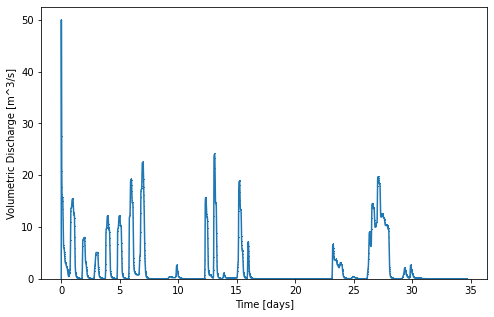

In [9]:
output_dir1 = output_dir + 'degree_day/'
os.chdir(output_dir1)
var_index = 0
nc_file = case_prefix + '_0D-Q.nc'
# nc_file = case_prefix + '_0D-d.nc'
# nc_file = case_prefix + '_0D-u.nc'

tfvis.plot_time_series(nc_file, output_dir=output_dir1, var_index=var_index,
                       marker=',', REPORT=True, xsize=8, ysize=5)

var_names in netCDF file =
['hs_13_44']
var longitudes =
[-120.20468888888888]
var latitudes =
[39.433900000000335]



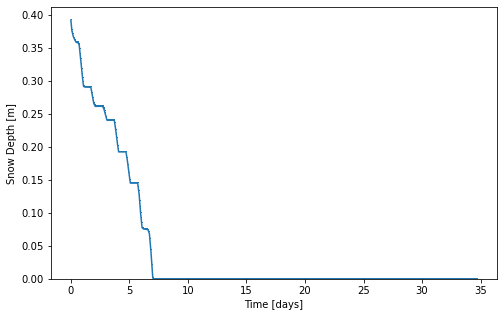

In [6]:
nc_file = case_prefix + '_0D-hsnow.nc'
# nc_file = case_prefix + '_0D-SMrate.nc'

tfvis.plot_time_series(nc_file, output_dir=output_dir1, var_index=var_index,
                       marker=',', REPORT=True, xsize=8, ysize=5)

## Visualize Output for Run with Snow Energy-Balance Component <a id="vis_en_bal_S"></a>


In [6]:
output_dir2 = output_dir + 'energy_balance/'
os.chdir(output_dir2)
var_index = 0
nc_file = case_prefix + '_0D-Q.nc'
# nc_file = case_prefix + '_0D-d.nc'
# nc_file = case_prefix + '_0D-u.nc'

tfvis.plot_time_series(nc_file, output_dir=output_dir2, var_index=var_index,
                       marker=',', REPORT=True, xsize=8, ysize=5)

In [ ]:
nc_file = case_prefix + '_0D-hsnow.nc'
# nc_file = case_prefix + '_0D-SMrate.nc'

tfvis.plot_time_series(nc_file, output_dir=output_dir, var_index=var_index,
                       marker=',', REPORT=True, xsize=8, ysize=5)

## Other Jupyter Notebooks for TopoFlow 3.6  <a id="notebooks_S"></a>

There is a growing collection of Jupyter notebooks to demonstrate the functionality of the TopoFlow 3.6 hydrologic model and its numerous utilities.  These are all available at:
https://github.com/peckhams/topoflow36/tree/master/notebooks.

Peckham, S.D. (2019) A Jupyter notebook for getting started with TopoFlow 3.6.  https://github.com/peckhams/topoflow36/blob/master/notebooks/TopoFlow_Getting_Started.ipynb.

Peckham, S.D. (2019) A Jupyter notebook to illustrate new data preparation utilities in TopoFlow 3.6.
https://github.com/peckhams/topoflow36/blob/master/notebooks/TopoFlow_Prepare_Input_Data.ipynb

Peckham, S.D. (2019) A Jupyter notebook to create visualizations of model output from TopoFlow 3.6. (version 2) https://github.com/peckhams/topoflow36/blob/master/notebooks/TopoFlow_Visualization.ipynb.

Peckham, S.D. (2020) A Jupyter notebook that discusses the use of global rainfall products such as GPM and GLDAS as inputs to TopoFlow.
https://github.com/peckhams/topoflow36/blob/master/notebooks/TopoFlow_Rainfall_Inputs.ipynb.

Peckham, S.D. (2020) A Jupyter notebook with a simple model calibration exercise for TopoFlow 3.6, using gauge data.
https://github.com/peckhams/topoflow36/blob/master/notebooks/TopoFlow_Calibration_Gauge_Data.ipynb.

Peckham, S.D. (2020) A Jupyter notebook to check and explore the TopoFlow solar radiation utilities, which includes shortwave and longwave radiation calculators.
https://github.com/peckhams/topoflow36/blob/master/notebooks/TopoFlow_Solar_Radiation_Demo.ipynb

## Key References for TopoFlow  <a id="refs_S"></a>

Peckham, S.D., M. Stoica, E.E. Jafarov, A. Endalamaw and W.R. Bolton (2017) Reproducible, component-based modeling with TopoFlow, a spatial hydrologic modeling toolkit, Earth and Space Science,4(6), 377-394, special issue: Geoscience Papers of the Future, American Geophysical Union, http://dx.doi.org/10.1002/2016EA000237.

Peckham, S.D. (2009) Geomorphometry and spatial hydrologic modeling, In: Hengl, T. and Reuter, H.I. (Eds), Geomorphometry: Concepts, Software and Applications, Chapter 25, Developments in Soil Science, vol. 33, Elsevier, 579-602, http://dx.doi.org/10.1016/S0166-2481(08)00025-1.  (TopoFlow)

Jiang, P., M. Elag, P. Kumar, S.D. Peckham, L. Marini, R. Liu (2017) A service-oriented architecture for coupling web service models using the Basic Model Interface (BMI), Environmental Modelling & Software, 92, 107-118, http://dx.doi.org/10.1016/j.envsoft.2017.01.021.

Zhang, Z., D.L. Kane and L.D. Hinzman (2000) Development and application of a spatially-distributed Arctic hydrological and thermal process model (ARHYTHM),
Hydrological Processes, 14(6), 1017-1044,
<a href="https://doi.org/10.1002/(SICI)1099-1085(20000430)14:6<1017::AID-HYP982>3.0.CO;2-G">
    https://doi.org/10.1002/(SICI)1099-1085(20000430)14:6<1017::AID-HYP982>3.0.CO;2-G</a>.

Peckham, S.D. (2014a) EMELI 1.0:  An experimental smart modeling framework for automatic coupling of self-describing models, Proceedings of HIC 2014, 11th International Conf. on Hydroinformatics, New York, NY. CUNY Academic Works, http://academicworks.cuny.edu/cc_conf_hic/464/.

Peckham, S.D. (2014b) The CSDMS Standard Names:  Cross-domain naming conventions for describing process models, data sets and their associated variables, Proceedings of the 7th Intl. Congress on Env. Modelling and Software, International Environmental Modelling and Software Society (iEMSs), San Diego, CA. (Eds.  D.P. Ames, N.W.T. Quinn, A.E. Rizzoli),  Paper 12. http://scholarsarchive.byu.edu/iemssconference/2014/Stream-A/12/.

Peckham, S.D., E.W.H. Hutton and B. Norris (2013) A component-based approach to integrated modeling in the geosciences: The Design of CSDMS, Computers & Geosciences, special issue: Modeling for Environmental Change, 53, 3-12, http://dx.doi.org/10.1016/j.cageo.2012.04.002.

Peckham, S.D. (2018) Using the open-source TopoFlow Python package for extracting D8 grids from DEMs and for fluvial landscape evolution modeling, Proceedings of Geomorphometry 2018, Boulder, CO, pp. O-11-1 to O-11-4, http://2018.geomorphometry.org/Peckham_2018_geomorphometry.pdf


## Appendix 1: Installing TopoFlow in a conda Environment  <a id="setup_S"></a>

To run this Jupyter notebook, it is recommended to use Python 3.7 from an Anaconda distribution and to install the required Python packages in a conda environment called <b>tf36</b>.  This prevents conflicts with other Python packages you may have installed.
The Anaconda distribution includes many packages from the
[<b>Python Standard Library</b>](https://docs.python.org/3/library/).

First, download the TopoFlow 3.6 package from GitHub repo "topoflow36" at:
<b>https://github.com/peckhams/topoflow36</b>.
Copy or unzip the package into some directory on your computer.  Let's refer to this full path as TF36_DIR.  e.g. TF36_DIR = /Users/peckhams/Dropbox/TopoFlow_3.6

Installing TopoFlow 3.6 with pip causes most of its dependencies to be installed automatically.  However, if you want to run the growing collection of Jupyter notebooks (such as this one) that highlight TopoFlow functionality, you will also need to install the
[<b>nb_conda</b>](https://docs.anaconda.com/anaconda/user-guide/tasks/use-jupyter-notebook-extensions/) package, and optionally the <b>jupyterlab</b> package (see below).
In addition, some of the new TopoFlow utilities (e.g. regrid.py and visualize.py) require the
[<b>gdal</b>](https://pypi.org/project/GDAL/) and
[<b>matplotlib</b>](https://matplotlib.org/) packages.
Simply type the following commands at an OS prompt after installing Anaconda and downloading TopoFlow.

``` bash
% conda update -n base conda
% conda create --name tf36
% conda activate tf36
% conda list
% conda install nb_conda
% conda install gdal
% conda install matplotlib
% conda install imageio
% pip install imageio-ffmpeg  (an imageio extension)
% cd TF36_DIR
% pip install -e .   (-e is the editable/developer option)
```

<b>Note:</b>  The <b>pip</b> package manager is used to install TopoFlow 3.6, since it is not available as a conda package.  (It gets installed when you install <b>nb_conda</b>.) However, like conda, pip will install a package and its dependencies into the currently active conda environment, as explained
[<b>in these docs</b>](https://docs.conda.io/projects/conda/en/4.6.1/user-guide/tasks/manage-pkgs.html#installing-non-conda-packages).  If you switch to another environment with <b>conda activate envname</b>, you can confirm that topoflow (or cfunits, gdal, netcdf4, etc.) is not there with <b>conda list</b>. 

<b>Note:</b>  Some of the new TopoFlow utilities use a Python package version of [<b>GDAL</b>](https://pypi.org/project/GDAL/).  At the time of this writing, installing <b>gdal</b> from the <b>conda-forge </b> with <i>conda install -c conda-forge gdal</i> did not work.

<b>Note:</b> The netCDF4 package will be installed as a TopoFlow dependency.

#### <b>Conda Environments</b>

Note that <b>conda</b> is the name of the package manager for the popular Anaconda Python distribution.  One feature of conda is support for multiple environments, which are isolated from one another.  When you install Anaconda, an environment called <b>base</b> is created for you and a base set of commonly-used Python packages are installed there.  However, you can (and should!) create additional, named environments and install different sets of Python packages into them without worrying about potential conflicts with packages in other environments.  Type <b>conda env list</b> to list your available environments. You can switch to one of your other environments using the command <b>conda activate envname</b>.  (Replace "envname" with the name of an environment.) You can switch back to the base environment with the command <b>conda deactivate</b>.  It is better not to install new packages into the base environment.  See the online conda documentation on [<b>Managing Environments</b>](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) for more information.

It is always a good idea to update conda itself before creating new environments and installing packages in them. The "-n" flag is followed by the name of the environment to update, and the "-c" flag is followed by the name of the <b>channel</b> from which to get packages.  A channel is a collection of Python packages that are provided and maintained by some group.  The word "defaults" refers to
[<b>Anaconda's own collection</b>](https://docs.anaconda.com/anaconda/packages/pkg-docs/), while
[<b>conda-forge</b>](https://conda-forge.org/feedstocks/)
refers to another popular collection and the GitHub organization that maintains it.  Many Python packages are available from both of these channels.  (However, the ipyleaflet and pydap  packages are currently not available in the Anaconda collection.) When you are installing several packages into an environment, the potential for installation problems seems to be less if you get them all from the same channel.  Keep in mind that packages you install will likely depend on many other Python packages, so there is a potential for conflicts, usually related to different package versions.  Using conda environments helps to mitigate against this and helps with <b>reproducibility</b>.

Once you've switched to an environment with <b>conda activate envname</b>, you can type <b>conda list</b> to see a list of packages.  If you do this right after you create a new environment you will see that it contains no packages.  If you do this right after installing each package above you will see that:

<ul>
    <li>Installing <b>nb_conda</b> triggers installation of <b>nb_conda_kernels</b> (2.2.3),
        <b>ipykernel</b> (5.3.0), <b>notebook</b> (6.0.3), <b>pip</b> (20.0.2),
        <b>setuptools</b> (46.4.0) and <b>traitlets</b> (4.3.3), among many others. 
    <li>Installing <b>gdal</b> triggers installation of #######.
    <li>Installing <b>matplotlib</b> triggers installation of ##########. 
</ul>

#### <b>Jupyter Notebook Extensions</b>

Note that <b>nb_conda</b> is installed first above, and triggers installation of <b>nb_conda_kernels</b> along with <b>notebook</b>.  This is important as it makes your Jupyter notebook app aware of your conda environments and available in the app as "kernels".  Anaconda provides a helpful page on the
[<b>Jupyter Notebook Extensions</b>](https://docs.continuum.io/anaconda/user-guide/tasks/use-jupyter-notebook-extensions/).
That page also explains how you can enable or disable these extensions individually. The command <b>jupyter nbextension list</b> shows you the extensions that are installed and whether they are enabled.  If you run the <b>jupyter notebook</b> or <b>jupyter lab</b> command in an environment that has <b>nb_conda_kernels</b> installed (see below), you will have the ability to associate one of your available conda environments with any new notebook you create.  Different environments give rise to different <b>kernels</b> in Jupyter, and the kernel name includes the environment name, e.g. <b>Python \[conda env:tf36\]</b>.  The kernel name is displayed in the upper right corner.  Notebooks typically open with the "environment kernel" they were created with. However, there is a <b>Change Kernel</b> option in the <b>Kernel</b> menu in the Jupyter app menu bar. (After changing the kernel, you may need to choose <b>Restart</b> from the <b>Kernel</b> menu.

#### <b>Cloning a conda Environment</b>

If your notebook is working but then you want to import additional packages (possibly with many dependencies, and potential for problems), you can keep the first environment but clone it with
<b><i>conda create --name clonename --copy --clone envname</i></b>,
and then install the additional packages in the clone.  This way, you can switch to the new environment's kernel and try to run your notebook, but if you run into any problems you can easily revert back to the original environment and functionality.

<b>Note:</b> Setting the "--copy" flag installs all packages using copies instead of hard or soft links.  This is necessary to avoid problems when using <b>pip</b> together with <b>conda</b> as described [<b>on this page</b>](https://stackoverflow.com/questions/43879119/installing-tensorflow-in-cloned-conda-environment-breaks-conda-environment-it-wa).

#### <b>Running Notebooks in the Jupyter Notebook App</b>

When you want to run the notebook, type <b>conda activate tf36</b> (at an OS command prompt) to activate this environment.  Then change to the directory that contains this notebook and type <b>jupyter notebook</b>.  By default, this folder is called <b>Jupyter</b> and is in your home directory.  In the app, choose this notebook by name, "TopoFlow_Getting_Started.ipynb", and make sure to choose the kernel called:  <b>Python \[conda env:tf36\]</b>.  See the References section at the end for more info.

#### <b>Running Notebooks in the JupyterLab App</b>

The
[<b>JupyterLab</b>](https://jupyterlab.readthedocs.io/en/stable/index.html)
app is a cool, new successor to the Notebook app and offers many additional features.  If you want to use this notebook in JupyterLab, you need to install one more Python package, as follows.

``` bash
% conda activate tf36
% conda install jupyterlab
```

You launch the JupyterLab app by typing <b>jupyter lab</b> instead of <b>jupyter notebook</b>.  To quit, choose <b>Logout</b> or <b>Shutdown</b> from the app's <b>File</b> menu.

#### <b>JupyterLab Extensions</b>

The Jupyter project provides documentation on
[<b>JupyterLab Extensions</b>](https://jupyterlab.readthedocs.io/en/stable/user/extensions.html)
which add capabilities to JupyterLab.  For example, after installing jupyterlab (see just above), if you want to use the <b>ipywidgets</b> and <b>ipyleaflet</b> Python packages, you need to install two extensions, as follows:
```
% conda activate tf36
% jupyter labextension install jupyter-leaflet
% jupyter labextension install @jupyter-widgets/jupyterlab-manager
```
To list the jupyter labextensions you have, and to see whether or not they are enabled, type <b>jupyter labextension list</b>.  <b>Note:</b> If you start jupyterlab from a conda environment in which a given extension is not installed, and then open or switch to a notebook which uses a different "environment kernel", one that requires that extension, the notebook may not work.

You should only install trusted extensions, due to security concerns, as explained in the documentation.  Third-party extensions pose a potential security risk.  An extension that allows you to play MP4 movie files in JupyterLab is
[<b>available on GitHub</b>](https://github.com/jupyterlab/jupyterlab-mp4)
(by Ian Rose of the JupyterLab organization)
and can be installed with the command:
```
% jupyter labextension install @jupyterlab/mp4-extension
```
<b>Note:</b> This command is from a pull-request on the extension's github repo.
Using the command: "jupyter labextension install jupyterlab-mp4" results in the
following error message:<br>
An error occured.
ValueError: "jupyterlab-mp4" is not a valid npm package

As of May 27, 2020, JupyterLab has added an experimental <b>Extension Manager</b> which can be enabled by choosing Settings > Enable Extension Manager in the app.
